# Problem Set - Gaussian Processes 

In [352]:
# The modules we will be using in this problem set
import util, test # These are local modules please feel free to read through them
from importlib import reload
reload(util)
reload(test)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## Gaussian Processes##

In this problem set, you will gain a deeper understanding of how Gaussian processes work by working on building a small library for Gaussian regression and classification. If you are having serious problems with this Pset please feel free to ask on Piazza or refer to [Gaussian Process: A Quick Introduction](A Quick Intro To Gaussian Processes.pdf).

### Problems
1. [Part 1 - Overview](#Part-1---Overview)
  1. [Problem 1 (10 pts)](#Problem-1---Making-a-Simple-Kernal-%2810-pts%29)
  2. [Problem 2 (5 pts)](#Problem-2---Making-a-Periodic-Kernal-%285-pts%29)
2. [Part 2 - Regression](#Part-2---Regression)
  1. [Problem 3 (5 pts)](#Problem-3---Getting-K-Matrix-%285-pts%29)
  2. [Problem 4 (20 pts)](#Problem-4---Regression-GP-%2820-pts%29)
  3. [Problem 5 (5 pts)](#Problem-5---Manual-Parameter-Tuning-%285-pts%29) 
  4. [Problem 6 (10 pts)](#Problem-6---Optimal-Parameters-%2810-pts%29)
3. [Part 3 - Classification](#Part-3---Classification)
  1. [Problem 7 (10 points)](#Problem-7---Solving-for-F-%2810-pts%29)
  2. [Problem 8 (5 points)](#Problem-8---Calculating-W-and-K'-%285-pts%29)
  3. [Problem 9 (20 points)](#Problem-9---Finding-the-Latent-Function-%2820-pts%29)
  4. [Problem 10 (10 points)](#Problem-10---Optimizing-Parameters-%2810-pts%29)

# Part 1 - Overview

As covered in lecture, Gaussian Processes (GPs) allow us to infer entire functions from a set of observations without extensive initial parametrizing. The power of GPs lies in the covariance matrix, which specifies the pairwise covariance between all of the points in your dataset. Knowing how a point is affected by all other points in the data allows us to adjust our beliefs about the shape of the underlying function as well as the uncertainty around this function every time a new observation is made.
//The first step is to make the matrix where each entry specifies the similarity between 2 points.//

## Problem 1 - Making a Simple Kernel (10 pts)

In the following problem, you will be designing a kernel for a dataset where your belief at a certain point is most affected by its neighbors. This behavior occurs everywhere in nature: when throwing a ball in the air, your most recent location will tell you the most information about where the ball will be next. 

The kernel you will implement below is the one we have focused on in our lecture:


$$ k(x, x') = \overbrace{\sigma_{f}^{2}}^{\text{prior covariance}}\cdot\hspace{2em}\exp\bigg[{\frac{-(x-x')^{2}}{{2l^{2}}}}\bigg] + \overbrace{\sigma_{n}^{2}}^{\text{measurement noise}}\cdot\hspace{2em}\delta(x, x')\,$$ where $$\delta(x_{i}, x_{j})= \begin{cases} 1 & \text{if}\ x_{i}=x{j} \\0 & \text{otherwise} \end{cases}$$


You can see clearly that the maximum allowed covariance will be $ \sigma_{f}^{2} + \sigma_{n}^{2}$. If $x \approx x′$, then $k(x, x′)$ approaches this maximum, meaning $f(x)$ is nearly perfectly correlated with $f(x′)$. This is good: for our function to look smooth, neighbours must be alike.

Now if $x$ is very distant from $x′$, we have instead $k(x,x′) \approx 0$, i.e. the two points cannot ‘see’ each other. So, for example, during interpolation at new $x$ values, distant observations will have negligible effect. 

How much effect this separation has will depend on the length parameter, $l$. You will see the effect of changing $l$ later on in the assignment.

In the following cell, please implement the `kernel()` function as per the equation above.

In [286]:
def kernel(x0, x1, params, sigma_n):
    """
    Runs the exponential kernal function and returns output
    :param x0: numpy array with values of x
    :param x1: numpy array with values of x'
    :param params: [float simga_f, float l]
    :param sigma_n: float sigma_n
    :return: np.array of kernel described above
    """
    diff = np.subtract.outer(x0, x1) # USE THIS FOR CALCULATING (x-x') #+
    value = params[0]**2 * np.exp( -0.5 * (1.0/params[1]**2) * diff**2) #-
    value[np.where(diff == 0.0)] += sigma_n**2 #-
    return value #-

In [287]:
reload(test)
test.test_simple_kernel(kernel)

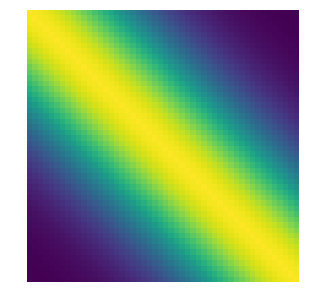

In [288]:
x = np.arange(-5, 5, 0.25)
sigma_n = 0.1
params = [1, 3]
K = kernel(x, x, params, sigma_n)
util.visiualize_kernel(K)

Here we can see the output of the kernel(x, x') where x = x' = [-5, -4.75, -4.5, ..., 4.5, 4.75, 5].
Along the diagonal you see that the kernel produces a higher value for when x and x' are near each other. Try changing the values of params. Notice how the band size changes. Think about the implications of these affects. This kernal attempts measure the similarity between any two points, this similarity measurement is very important in the Gaussian Process

## Problem 2 - Making a Periodic Kernel (5 pts)

In [289]:
def periodic_kernel(x0, x1, params, sigma_n):
    """
    Runs the Periodic kernal described above
    :param x0: numpy array with values of x
    :param x1: numpy array with values of x'
    :param params: [float simga_f1, float l, float simga_f1, float nu]
    :param sigma_n: float sigma_n
    :return: np.array of periodic_kernel described above
    """
    diff = np.subtract.outer(x0, x1) # USE THIS FOR CALCULATING (x-x') #+
    value = params[0]**2 * np.exp( -0.5 * (1.0/params[1]**2) * diff**2) #-
    value += params[2]**2 * np.exp(-2 * np.sin(params[3]*diff)**2) #-
    value[np.where(diff == 0.0)] += sigma_n**2 #-
    return value

In [290]:
test.test_periodic_kernel(periodic_kernel)

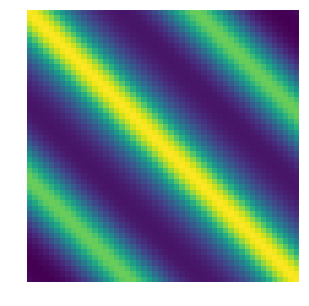

In [291]:
x = np.linspace(-5, 5, 50)
sigma_n = 0.1
params = [1, 2, 1, 1]
K = periodic_kernel(x, x, params, sigma_n)
util.visiualize_kernel(K)

Here we can see the output of the periodic_kernel(x, x') where x = x' = [-5, -4.75, -4.5, ..., 4.5, 4.75, 5].
Again notice the bands that formed along the diagonal; however, with the periodic function now notice that we have extra bands, these bands represent the periodic nature of the function. Try changing the values of params. Notice how the band size changes and the how tight the bands are change. Think about the implications of these affects.

# Part 2 - Regression

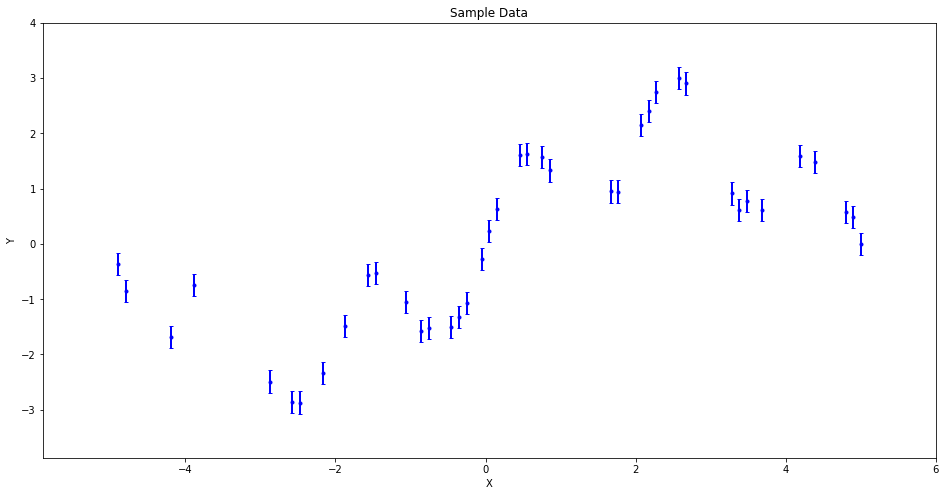

In [292]:
reload(util)
x, y = util.get_sample_data_1()
sigma_n = 0.1
util.scatter_raw_data(x, y, sigma_n)

## Problem 3 - Getting K Matrix (5 pts)

In [293]:
def get_Ks(x_new, x, kernel, theta):
    """
    Generates K, KS, and KSS by using the given kernel and theta
    :param x_new: numpy array of new data
    :param x: numpy array of data where we have sampled
    :param theta: params + [sigma_n] list that has the params talked about earlier 
    but also has sigma_n in the last index
    :return: np.array K, np.array KS, np.array KSS  all as described above.
    """
    K = kernel(x, x, theta[:-1], theta[-1]) # K
    KS = kernel(x_new, x, theta[:-1], theta[-1]) # K*
    KSS = kernel(x_new, x_new, theta[:-1], theta[-1]) # K**
    return K, KS, KSS

In [294]:
reload(test)
test.test_get_Ks(get_Ks, kernel)

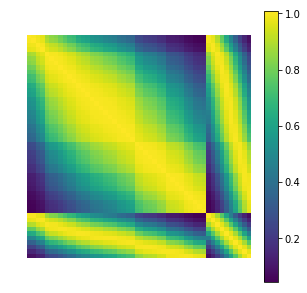

In [295]:
theta = [1, 4, sigma_n]
x_new = np.arange(-5,5)
K, KS, KSS = get_Ks(x_new, x, kernel, theta)
util.visiualize_Ks(K, KS, KSS)

Here you can see the joint Covariance Matrix this is $ \left[ \begin{matrix} K&K*^T\\ K*&K** \end{matrix} \right] $. You should be able to see the the sharp cutoffs between the different sub-matricies. The values in K and K* are not as smooth as they were in the previous section because the samples in this section where not drawn uniformely; however, they were sorted by their x value so that we could see the bands. Here again you can play with the parameters of theta and see how the matrix changes. Notice the bands in K* these bands come from similarities bettween x_new values and the originally sampled xs.

## Problem 4 - Regression GP (20 pts)

In [296]:
def regression_GP(x_new, x, y, kernel, theta):
    """
    Generates K, KS, and KSS by using the given kernel and theta
    :param x_new: numpy array of new data
    :param x: numpy array of data where we have sampled
    :param theta: params + [sigma_n] list that has the params talked about earlier 
    but also has sigma_n in the last index
    :return: np.array K, np.array KS, np.array KSS  all as described above.
    """
    K, KS, KSS = get_Ks(x_new, x, kernel, theta)

    y = np.matmul(np.matmul(KS, np.linalg.inv(K)),y)
    var = KSS - KS.dot(np.linalg.inv(K).dot(KS.T))
    var = np.diagonal(var)
    return(y.squeeze(), var.squeeze())

In [297]:
reload(test)
test.test_regression(regression_GP, kernel)

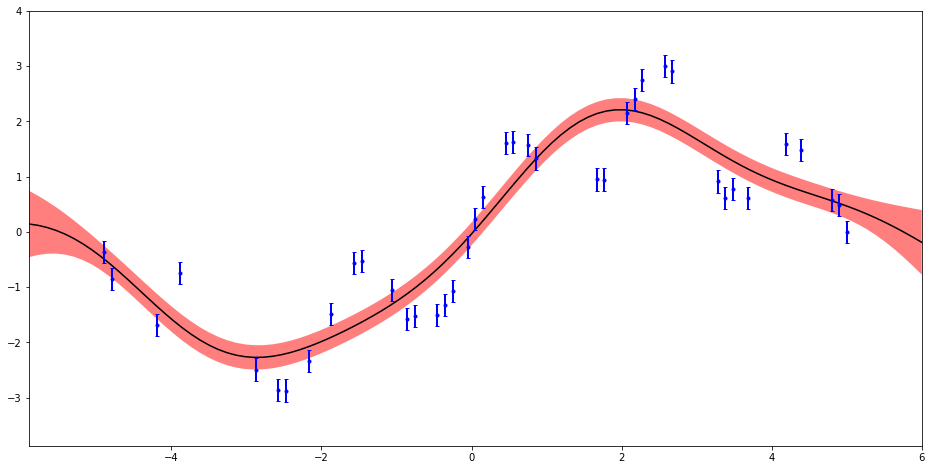

In [298]:
reload(util)
reload(test)
sigma_n = 0.1
theta = [1, 2, sigma_n]
util.solve_and_visualize(regression_GP, kernel, x, y, theta)

## Problem 5 - Manual Parameter Tuning (5 pts)

writing here 

Ask them what the happens as they change the values of theta above


What happens when you cange theta[0] (sigma_f)? 
What happens when you cange theta[1] (l)?
What happens when you cange sigma_n?

## Problem 6 - Optimal Parameters (10 pts)

In [299]:
def regression_optimize_theta(x, y, sigma_n, kernel, params_0=[0.1, 0.1]):
    def log_pY(theta):
        K = kernel(x, x, theta, sigma_n)
        log_k = np.linalg.slogdet(K)[1]
        output = 0.5 * np.matmul(np.matmul(y.T, np.linalg.inv(K)),y)
        output += 0.5 * log_k
        return output

    res = minimize(log_pY, params_0, method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
    return list(res.x) + [sigma_n]

In [300]:
reload(test)
test.test_regression_ouptimize_theta(regression_optimize_theta, kernel)

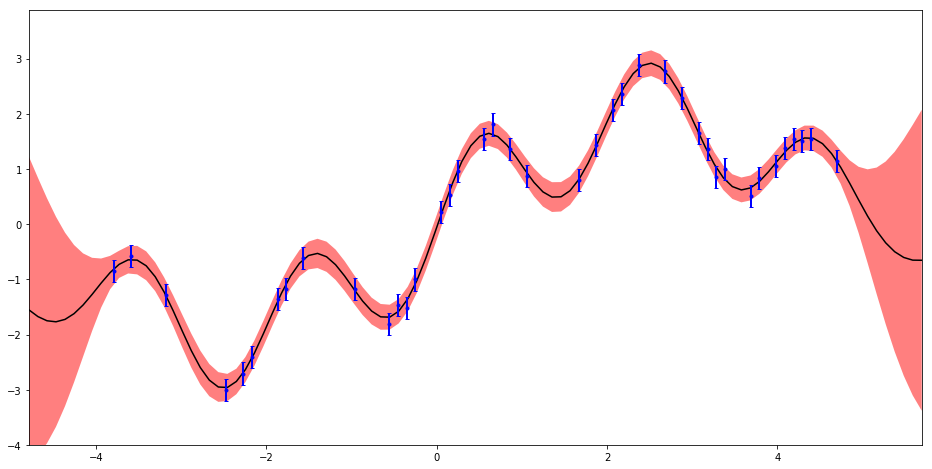

In [301]:
theta = regression_optimize_theta(x, y, sigma_n, kernel, [1, 0.1])
util.solve_and_visualize(regression_GP, kernel, x, y, theta)

# Part 3 - Classification

The goal of classification is to assign a new input $x$ to one of C classes in {$C_1$, $C_2$, ..., $C_n$}. In this PSet we will consider a binary classification problem (there are only 2 classes $C_1$ and $C_2$). 

We will focus on probablistic classifcation as discussed in lecture where we calculate the probability that an input variable belongs in a class. 

The problem of classification requires two steps.
1. Find the latent function, f, using gaussian processes
2. Calculate the predictive probability that x belonds to a class by "sqaushing" the latent function (this is done using the sigmoid function)




## Problem 7 - Solving for F (10 pts)

Description of a sigmoid function
<center>$S(x)$ = </center>
In this PSet use $S(x)$ as the sigmoid functiod in the implementation of the following problems

In this problem implement the sigmoid function $S(x)$ = $\dfrac{1}{1+e^{-x}}$
The sigmoid function, $S(x)$, is a simple but powerful function often used in binary classification. 

In [398]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

In [399]:
test.test_sigmoid(sigmoid)

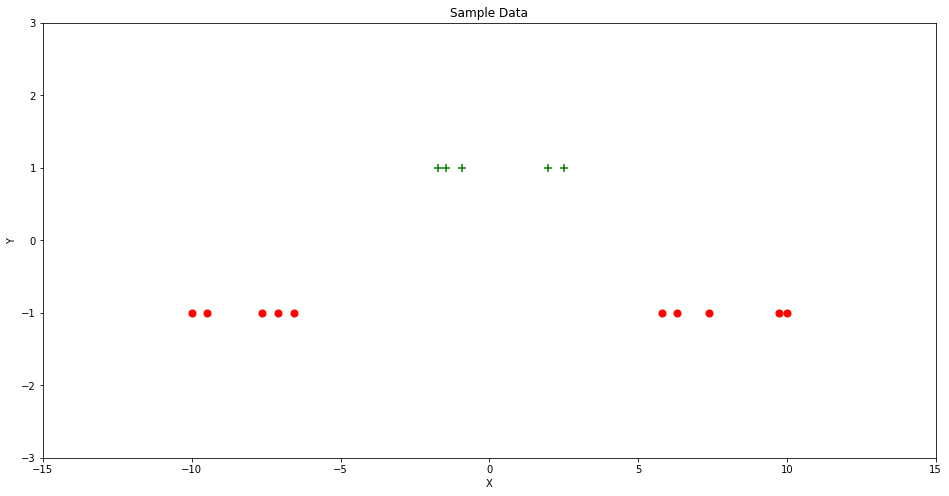

In [400]:
x, y = util.get_sample_classification_data()
util.scatter_raw_data_classification(x, y)

Solve for the covariance matrices K, K$*$, and K$**$ using the function you implemented above. Assume $\theta$ = [0.4, 5, 0]

In [401]:
theta = [.4, 5, 0]
K, KS, KSS = get_Ks(x, x, kernel, theta)

In [402]:
test.test_get_Ks(get_Ks, kernel)


In [403]:
def find_f(K, y):
    n = len(y) 
    f = np.zeros(n)  
    y_giv_f = np.zeros(n)
    grad = np.zeros(n)
    
    for i in range(0, 100):
        for j in range(n):
            y_giv_f[j] = sigmoid(f[j]*y[j])
            grad[j] = (1-y_giv_f[j])*y[j]
        f = np.array(np.matmul(K, grad)).flatten()
    for j in range(n):
        y_giv_f[j] = sigmoid(f[j]*y[j])
    return f, y_giv_f

In [404]:
test.test_find_f(find_f, get_Ks, kernel)

(array([-0.23770644, -0.25905189, -0.22084113, -0.11321433, -0.25408564,
         0.11599742,  0.09018878,  0.07808995,  0.12915915,  0.10725033,
        -0.16853327, -0.24581065, -0.25337059, -0.19440497, -0.23339006]),
 array([0.55914836, 0.56440321, 0.55498698, 0.52827339, 0.56318186,
        0.52896688, 0.52253192, 0.51951257, 0.53224497, 0.52678691,
        0.54203387, 0.56114509, 0.56300594, 0.54844875, 0.5580841 ]))

## Problem 8 - Calculating W and K' (5 pts)


Write a function that solves for W given f and y

In [405]:
def calc_W(f, y):
    n = len(y)
    W = np.zeros(n)
    for j in range(n):
        sigmoid_v = sigmoid(f[j]*y[j])
        W[j] = y[j]**2 * (1-sigmoid_v)*sigmoid_v
    return W

In [406]:
test.test_calc_W(calc_W, find_f, get_Ks, kernel)

array([0.24650147, 0.24585223, 0.24697643, 0.24920062, 0.24600805,
       0.24916092, 0.24949231, 0.24961926, 0.24896026, 0.24928246,
       0.24823315, 0.24626128, 0.24603025, 0.24765272, 0.24662624])

Write a function that solves for $K'$

In [407]:
def calculate_KP(K, W):
    return K + (1.0/W)

In [408]:
test.test_calc_KP(calculate_KP, calc_W, find_f, get_Ks, kernel)

array([[4.21677092, 4.22203866, 4.20808537, 4.15213672, 4.22292551,
        4.07848111, 4.02867587, 4.02453451, 4.07283898, 4.08118595,
        4.03089477, 4.06138343, 4.06500078, 4.03968991, 4.05564307],
       [4.21132557, 4.22748401, 4.1984709 , 4.12999106, 4.22402361,
        4.05758281, 4.01977815, 4.01640424, 4.05375364, 4.05944845,
        4.02956386, 4.06099241, 4.06472141, 4.03869211, 4.05510226],
       [4.21588694, 4.21698556, 4.20896934, 4.15925879, 4.21946224,
        4.08793218, 4.03341798, 4.02891707, 4.0817159 , 4.09087383,
        4.03174011, 4.06165217, 4.06519652, 4.04033648, 4.0560076 ],
       [4.19607646, 4.18464389, 4.19539695, 4.17283118, 4.19151636,
        4.12818169, 4.06008393, 4.05403592, 4.12139542, 4.13109166,
        4.03815466, 4.06399709, 4.06696484, 4.04541783, 4.05907954],
       [4.21478884, 4.22660004, 4.203524  , 4.13943995, 4.22490759,
        4.06541489, 4.02286805, 4.01921202, 4.0608176 , 4.06764735,
        4.02998648, 4.06111137, 4.0648055 , 

## Problem 9 - Finding the Latent Function (20 pts)


Now we have all the necessary components. 

In [409]:
def GPC(x_new, x, y, kernel, theta):
    K = kernel(x, x, theta[:-1], theta[-1]) # K
    KS = kernel(x_new, x, theta[:-1], theta[-1]) # K*
    KSS = kernel(x_new, x_new, theta[:-1], theta[-1]) # K**
    
    f, y_giv_f = find_f(K, y)
    W = calc_W(f, y)
    
    KP = calculate_KP(K, W)

    f_bar = np.matmul(np.matmul(KS, np.linalg.inv(K)), f)    
    var = KSS - KS.dot(np.linalg.inv(KP).dot(KS.T))
    var = np.diagonal(var)
    return(f_bar.squeeze(), var.squeeze())


In [410]:
test.test_GPC(GPC, calculate_KP, calc_W, find_f, get_Ks, kernel)

(array([-0.14693125, -0.16776467, -0.188432  , -0.20815161, -0.2259643 ,
        -0.24094705, -0.25209113, -0.25852281, -0.25945684, -0.2543002 ,
        -0.24272057, -0.22470007, -0.20046277, -0.17066447, -0.136189  ,
        -0.09823815, -0.05853066, -0.01844872,  0.02015105,  0.05554001,
         0.08609911,  0.11055446,  0.12743009,  0.13617765,  0.13619729,
         0.12774151,  0.11078103,  0.08648205,  0.05597896,  0.02051031,
        -0.0181839 , -0.05824847, -0.09797888, -0.13568527, -0.16992408,
        -0.19944317, -0.22322483, -0.24071018, -0.25163924, -0.25606534,
        -0.25441077, -0.24726846, -0.2354771 , -0.21998621, -0.20178319,
        -0.18184229, -0.1611024 , -0.14037656, -0.12034341, -0.10153183]),
 array([0.04562361, 0.04616513, 0.04655099, 0.04681222, 0.04698885,
        0.04710911, 0.04719327, 0.04723695, 0.04725126, 0.04721087,
        0.04715417, 0.04703736, 0.04696599, 0.04683762, 0.04675739,
        0.04663158, 0.04651872, 0.04648113, 0.04642249, 0.046440

## Problem 10 - Optimizing Parameters (10 pts)


We provided you with $\theta$, now write a function that optimizes $\theta$ for you. Ouput of function is a list.

In [353]:

def optimize_theta(x, y, kernel, params_0=[0.1, 0.1], sigma_n=0.1):
    def log_pY(theta):
        K = np.matrix(kernel(x, x, theta, sigma_n))
        f, y_giv_f = find_f(K, y)
        W = calc_W(f, y)
        inv_k = np.linalg.inv(K)
        log_k = np.log(np.linalg.det(K) * np.linalg.det(inv_k+W))
        Y_giv_f = np.prod(y_giv_f)
        output = 0.5 * np.matmul(np.matmul(f.T, inv_k),f)
        output += 0.5 * log_k
        output -= np.log(Y_giv_f)
        return output

    res = minimize(log_pY, params_0, method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
    return list(res.x) + [sigma_n]

In [354]:
test.test_optimize_theta(optimize_theta, kernel)

[1.8165855832464077, 0.3220360502776173, 0.1]

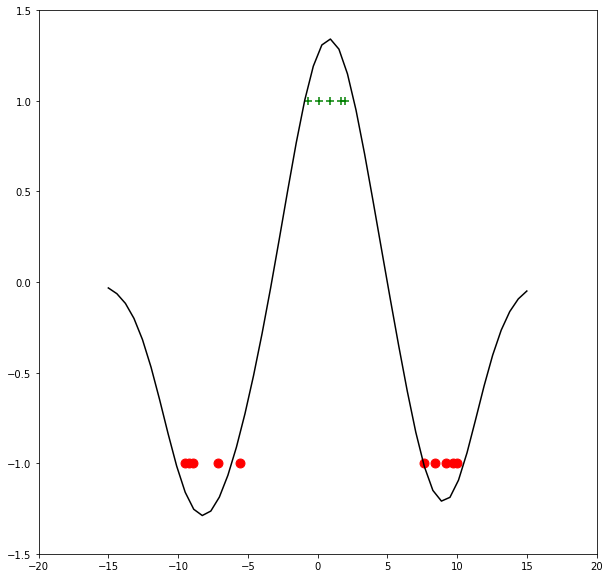

In [363]:
x_new = np.linspace(-15, 15, 50)
params_0 = [.4, 5]
sigma_n = 0.1
theta = optimize_theta(x, y, kernel, params_0=params_0, sigma_n=sigma_n)
y_bar, var = GPC(x_new, x, y, kernel, theta)

fig, axs = plt.subplots(1, 1)
for i in range(len(x)):
    if y[i] > 0:
        axs.scatter(x[i], y[i], 80, marker='+', color='g')
    else:
        axs.scatter(x[i], y[i], 80, marker='o', color='r')
axs.plot(x_new, y_bar,  color='k')
pretty_plot(fig, axs)